# Tutorial: Calculating Peak-Gene Association / DORC score using scPrinter

In [1]:
%load_ext autoreload
%autoreload 2
import scprinter as scp
import pandas as pd
import os
import numpy as np
import scanpy as sc
import anndata
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
main_data_dir = '/ewsc/rzhang/RS_HumanCD34'

In [3]:
adata_rna = anndata.read_h5ad(os.path.join(main_data_dir, 'rna_filtered_qc1.h5ad'))
adata_atac = anndata.read_h5ad(os.path.join(main_data_dir, 'atac_peak_v2_rmdblt.step1.h5ad'))

In [4]:
adata_atac.obs['atac_label']
age = []
for d in np.array(adata_atac.obs['atac_label']):
    d = str(d)
    if 'old' in d:
        age.append('old')
    elif 'young' in d:
        age.append('young')
    else:
        dd = d.split("_")[-1][0]
        if dd == 'o':
            age.append('old')
        elif dd == 'y':
            age.append('young')
        else:
            age.append('unknown')
adata_atac.obs['age'] = age
adata_rna.obs['age'] = adata_atac.obs['age']

In [5]:
# subset to keep only shared barcodes
shared_index = list(set(adata_rna.obs.index) & set(adata_atac.obs.index))
adata_rna = adata_rna[shared_index].copy()
adata_atac = adata_atac[shared_index].copy()
adata_rna = adata_rna[adata_rna.obs['age'] != 'unknown'].copy()
adata_atac = adata_atac[adata_atac.obs['age'] != 'unknown'].copy()

In [6]:
adata_atac

AnnData object with n_obs × n_vars = 115122 × 388456
    obs: 'sample', 'fake', 'n_fragment', 'frac_dup', 'frac_mito', 'library', 'tsse', 'strict_filter', 'atac_label', 'rna_label', 'R1', 'R1_donor', 'replicate', 'doublet', 'doublet_str', '20_pc_doublet_prob', '30_pc_doublet_prob', '40_pc_doublet_prob', '20_pc_doublet_prob_clump', '30_pc_doublet_prob_clump', '40_pc_doublet_prob_clump', 'scrublet_mean_prob', 'scrublet_2nd_max_prob', 'scrublet_max_prob', 'leiden', 'leiden_50', 'leiden_100', 'leiden_150', 'leiden_200', 'leiden_250', 'leiden_res1', 'leiden_res2', 'leiden_res3', 'leiden_res1.5', 'UMAP_x', 'UMAP_y', 'leiden_final', 'age'
    uns: 'atac_label_colors', 'doublet_str_colors', 'leiden', 'leiden_res1_colors', 'leiden_res2_colors', 'leiden_res3_colors', 'library_colors', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_10', 'X_umap_100', 'X_umap_150', 'X_umap_20', 'X_umap_200', 'X_umap_250', 'X_umap_30', 'X_umap_50', 'X_umap_okish', 'cell_topics_100', 'cell

In [7]:
adata_rna

AnnData object with n_obs × n_vars = 115122 × 62703
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'library', 'strict_filter', 'sample', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'rna_doublet_score', 'rna_doublet_class', 'age'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [8]:
# normalize adata_rna by coverage, then log1p
sc.pp.normalize_total(adata_rna, 10000)
sc.pp.log1p(adata_rna)

/tmp/ipykernel_502838/1928536121.py:2: FutureWarning: The specified parameters ('target_sum',) are no longer positional. Please specify them like `target_sum=10000`
  sc.pp.normalize_total(adata_rna, 10000)


In [9]:
# calculate peak-gene association
import time
start = time.time()
dorc_all = scp.dorc.fast_gene_peak_corr(adata_atac,
                        adata_rna,
                        genome=scp.genome.hg38,
                        tss_df=scp.datasets.FigR_hg38TSSRanges,
                        gene_list=None,
                        window_pad_size=50000,
                        n_jobs=32,
                        n_bg=100,
                        pval_cut=None,
                        pos_only=True,
                        multimapping=False)
print ("takes", time.time() -start, "s")

Fetching GC content:   0%|          | 0/388456 [00:00<?, ?it/s]

Found 452201 Gene-Peak pairs
19314 Unique Genes
233498 Unique Peaks


Calculating Spearman correlation:   0%|          | 0/452201 [00:00<?, ?it/s]

Calculating Spearman correlation:   0%|          | 0/100000 [00:00<?, ?it/s]

Calculating p-values:   0%|          | 0/453 [00:00<?, ?it/s]

takes 519.1256625652313 s


In [10]:
dorc_all

,Gene,PeakRanges,rObs,pvalZ
300140,CPN1,chr10:100043252-100043552,0.002095,0.280820
300142,CPN1,chr10:100046181-100046481,0.004894,0.217062
300145,CPN1,chr10:100071852-100072152,0.004790,0.196456
300146,CPN1,chr10:100100787-100101087,0.009643,0.007843
300147,CPN1,chr10:100125512-100125812,0.001213,0.433347
...,...,...,...,...
339888,WWC3,chrX:9983329-9983629,0.016278,0.057461
339889,WWC3,chrX:9986814-9987114,0.016863,0.513499
339890,WWC3,chrX:9988917-9989217,0.002235,0.790801
339891,WWC3,chrX:9995693-9995993,0.019014,0.327712


In [11]:
# filter by pval first
dorc = dorc_all[dorc_all['pvalZ'] <= 0.05]

In [12]:
dorc

,Gene,PeakRanges,rObs,pvalZ
300146,CPN1,chr10:100100787-100101087,0.009643,7.842654e-03
113192,ERLIN1,chr10:100147396-100147696,0.021533,2.822567e-02
113193,ERLIN1,chr10:100148758-100149058,0.016549,2.137381e-02
292347,BLOC1S2,chr10:100266813-100267113,0.015113,3.682262e-02
392229,PKD2L1,chr10:100307623-100307923,0.021888,1.991858e-09
...,...,...,...,...
51095,SHROOM2,chrX:9746267-9746567,0.008453,4.633610e-02
435281,DIAPH2-AS1,chrX:97542129-97542429,0.010414,2.491993e-03
435288,DIAPH2-AS1,chrX:97568775-97569075,0.013521,8.381292e-04
51102,SHROOM2,chrX:9770549-9770849,0.007519,2.925663e-02


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


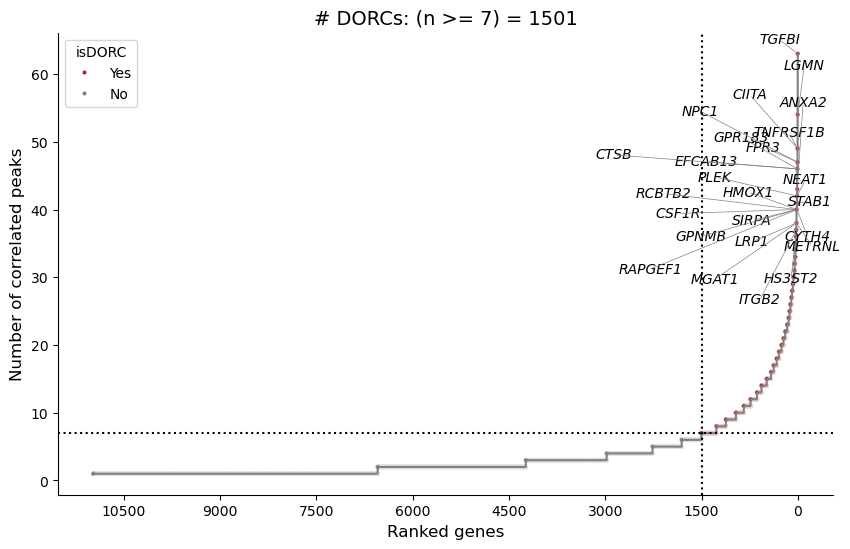

In [13]:
# Make j plot
gene_list = scp.dorc.dorc_j_plot(dorc, cutoff=7, 
                                 label_top=25, 
                                 return_gene_list=True
                )

In [14]:
# get dorc scores
import time
start = time.time()
adata_dorc = scp.dorc.get_dorc_score(
        adata_atac,
        dorc,
        normalize_atac=True,
        gene_list=gene_list,
)
print ("takes", time.time() -start, "s")

  0%|          | 0/1501 [00:00<?, ?it/s]

takes 16.769819259643555 s


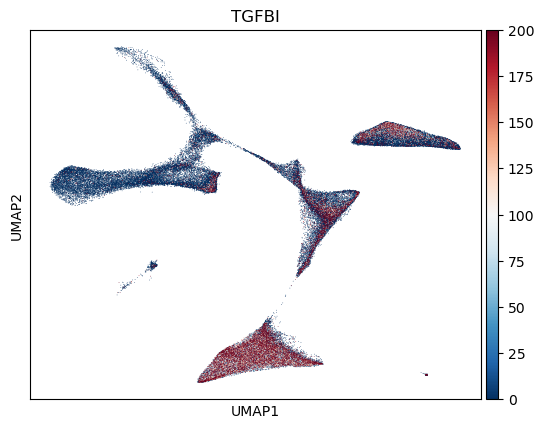

In [15]:
adata_dorc.obsm['X_umap'] = adata_atac.obsm['X_umap']
sc.pl.umap(adata_dorc, color='TGFBI', vmax=200, vmin=0, cmap='RdBu_r')

In [16]:
# consistent with R version
result_R = pd.read_csv(f'{main_data_dir}/full_peak2geneCorr.txt', sep='\t')
result_R.index = [f'{gene}_{peak}' for gene, peak in zip(result_R['Gene'], result_R['PeakRanges'])]
dorc_all.index = [f'{gene}_{peak}' for gene, peak in zip(dorc_all['Gene'], dorc_all['PeakRanges'])]
shared = set(result_R.index) & set(dorc_all.index)

In [17]:
a = dorc_all.loc[list(shared)]
b = result_R.loc[list(shared)]

In [18]:
mask1 = a['pvalZ'] < 0.05
mask2 = b['pvalZ'] < 0.05
np.sum(mask1 & mask2), np.sum(mask1 | mask2)

(32442, 46249)

Text(0.5, 1.0, 'pearsonr=0.92')

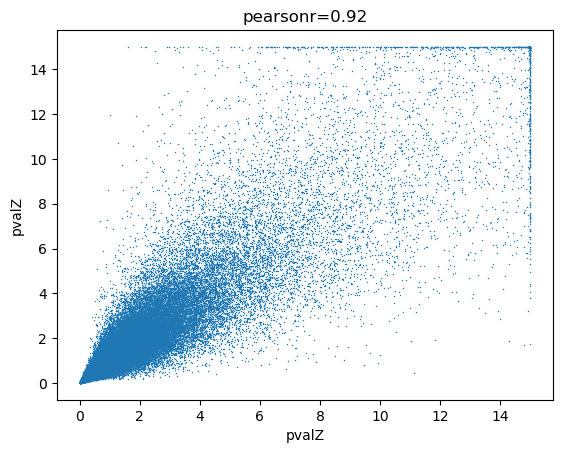

In [19]:
sns.scatterplot(x=-np.log10(a['pvalZ']+1e-15), y=-np.log10(b['pvalZ']+1e-15), s=1, linewidth=0)
plt.title('pearsonr=' + '%.2f' %(pearsonr(-np.log10(a['pvalZ'] + 1e-15), -np.log10(b['pvalZ'] + 1e-15))[0]))

Text(0.5, 1.0, 'pearsonr=0.99')

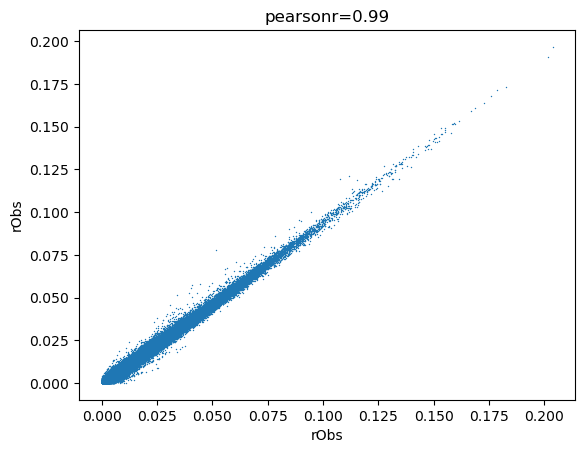

In [20]:
sns.scatterplot(x=a['rObs'], y=b['rObs'], s=1, linewidth=0)
plt.title('pearsonr=' + '%.2f' %(pearsonr(a['rObs'], b['rObs'])[0]))